## Prepare input structures

We first start by preparing the input ASE database. In the subfolder `golddac/test.xyz` there are a 312 total of MOF + gas configurations for 26 MOFs. The original `GoldDAC` dataset can be found at https://github.com/hspark1212/DAC-SIM/tree/main/assets/GoldDAC.

In [1]:
from dotenv import load_dotenv

load_dotenv()

from ase.io import read

atoms_list = read("golddac/test.xyz", index=":")

In [2]:
# Collect by MOF name
from collections import defaultdict

mof_dict = defaultdict(list)

for atoms in atoms_list:
    mof_name = atoms.info["group"]
    mof_dict[mof_name].append(atoms)
print(len(mof_dict))

26


## Demo Interaction (Adsorption) energy between MOF and gas molecules (CO2, H2O)

In [3]:
import pandas as pd
from ase import units

from tqdm.auto import tqdm
from mlip_arena.models import MLIPEnum
from mlip_arena.tasks.utils import get_calculator
from prefect import task, flow
from prefect.cache_policies import TASK_SOURCE, INPUTS

@task(cache_policy=TASK_SOURCE + INPUTS)
def calculate_interaction_energy(mof_dict, model):

    calc = get_calculator(
        calculator_name=model,
        calculator_kwargs=None,
        # dispersion=True,
        # dispersion_kwargs=dict(damping='bj', xc='pbe', cutoff=40.0 * units.Bohr),
    )
    
    results = []
    
    for mof_name, atoms_list in tqdm(mof_dict.items()):
    
        for atoms in atoms_list:
            name_split = atoms.info["name"].split("_")
            gas_name = name_split[1]
            region = name_split[2]  # R: repulsion E: equilibrium P: weak-attraction
            adsorption_type = name_split[3]  # N, A
            if adsorption_type == "A":
                dist = name_split[4]
            elif adsorption_type == "N":
                if region == "R" or region == "E":
                    dist = name_split[4].split("-")[1]
                elif region == "P":
                    dist = name_split[4].split("-")[0]
                else:
                    raise ValueError(f"Unknown region: {region}")
            else:
                raise ValueError(f"Unknown adsorption type: {adsorption_type}")
    
            # True energies (PBE+D3)
            true_te = atoms.info["DFT_E_total"]
            true_ie = atoms.info["DFT_E_int"]
    
            # Predicted energies
            tags = atoms.get_tags()
            framework_gas = atoms.copy()
            framework = framework_gas[tags == 0]
            gas = framework_gas[tags == 1]
    
            pred_te = calc.get_potential_energy(framework_gas)
            pred_ie = (
                pred_te
                - calc.get_potential_energy(framework)
                - calc.get_potential_energy(gas)
            )
    
            # Collect results
            row_data = {
                "mof_name": mof_name,
                "gas": gas_name,
                "model": model.name,
                "region": region,
                "adsorption_type": adsorption_type,
                "dist": dist,
                "true_te": true_te,
                "true_ie": true_ie,
                "pred_te": pred_te,
                "pred_ie": pred_ie,
            }
            results.append(row_data)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    df.to_pickle(f"{model.name}.pkl")
    
    return df

No module named 'deepmd'


In [4]:

models = ["MACE-MP(M)", "MACE-MPA", "MatterSim", "ORBv2"]

dfs = []

for model in MLIPEnum:

    if not model.name in models:
        continue
        
    df = calculate_interaction_energy(mof_dict, model)
    dfs.append(df)

df = pd.concat(dfs)

18:30:34.743 | INFO    | prefect - Starting temporary server on http://127.0.0.1:8945
See https://docs.prefect.io/3.0/manage/self-host#self-host-a-prefect-server for more information on running a dedicated Prefect server.

18:30:39.777 | INFO    | Task run 'calculate_interaction_energy' - Finished in state Cached(type=COMPLETED)

18:30:39.838 | INFO    | Task run 'calculate_interaction_energy' - Finished in state Cached(type=COMPLETED)

18:30:39.894 | INFO    | Task run 'calculate_interaction_energy' - Finished in state Cached(type=COMPLETED)

2025-01-19 18:30:40.114 | INFO     | mlip_arena.tasks.utils:get_freer_device:42 - Selected GPU cuda:0 with 81037.75 MB free memory from 4 GPUs
2025-01-19 18:30:40.115 | INFO     | mlip_arena.tasks.utils:get_calculator:71 - Using device: cuda:0
2025-01-19 18:30:42.759 | INFO     | mlip_arena.tasks.utils:get_calculator:90 - Using calculator: <mlip_arena.models.externals.mace-mp.MACE_MPA object at 0x7fc78c3b6510>
2025-01-19 18:30:42.760 | INFO     | mlip_arena.tasks.utils:get_calculator:92 - {'device': 'cuda:0'}


Default dtype float32 does not match model dtype float64, converting models to float32.


  0%|          | 0/26 [00:00<?, ?it/s]

18:31:21.431 | INFO    | Task run 'calculate_interaction_energy' - Finished in state Completed()

In [5]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np
df['mae_ie'] = np.abs(df['pred_ie'] - df['true_ie'])
df['mape_ie'] = np.abs((df['pred_ie'] - df['true_ie']) / df['true_ie'])
df

,mof_name,gas,model,region,adsorption_type,dist,true_te,true_ie,pred_te,pred_ie,mae_ie,mape_ie
0,Zn-CFA-1-OH,CO2,MACE-MP(M),P,A,5.0,-1196.705159,0.218382,-1188.404907,0.133060,0.085322,0.390699
1,Zn-CFA-1-OH,CO2,MACE-MP(M),R,A,2.0,-1196.413903,0.509638,-1188.130981,0.406515,0.103123,0.202345
2,Zn-CFA-1-OH,CO2,MACE-MP(M),P,A,4.0,-1196.897943,0.025598,-1188.628174,-0.089926,0.115524,4.512986
3,Zn-CFA-1-OH,CO2,MACE-MP(M),P,A,3.1,-1197.057199,-0.133657,-1188.796631,-0.259029,0.125372,0.938012
4,Zn-CFA-1-OH,CO2,MACE-MP(M),E,A,2.7,-1197.081989,-0.158448,-1188.791992,-0.254967,0.096519,0.609149
...,...,...,...,...,...,...,...,...,...,...,...,...
307,SIFSIX-3-Zn,H2O,MACE-MPA,R,N,0.9,-1405.071354,3.568739,-1403.415283,2.780888,0.787851,0.220765
308,SIFSIX-3-Zn,H2O,MACE-MPA,R,N,1.5,-1408.753954,-0.113861,-1406.903564,-0.707504,0.593644,5.213771
309,SIFSIX-3-Zn,H2O,MACE-MPA,P,N,2.6,-1408.482300,0.157793,-1406.473511,-0.277946,0.435739,2.761465
310,SIFSIX-3-Zn,H2O,MACE-MPA,P,N,1.3,-1408.749477,-0.109384,-1406.789917,-0.594074,0.484691,4.431105


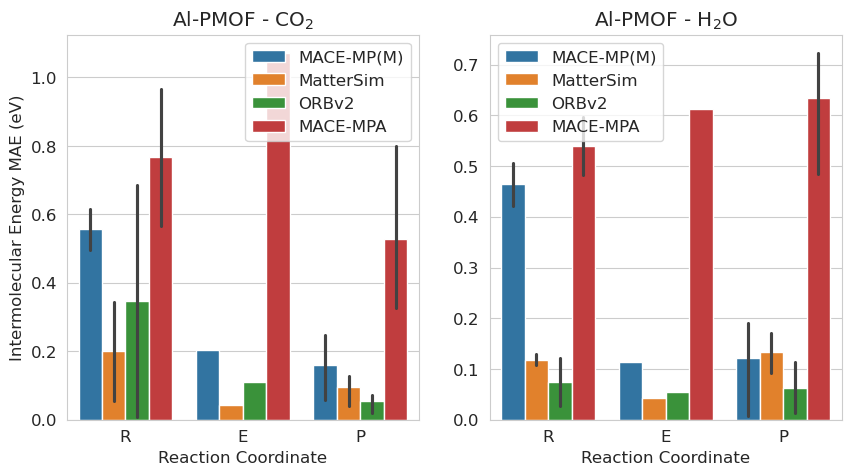

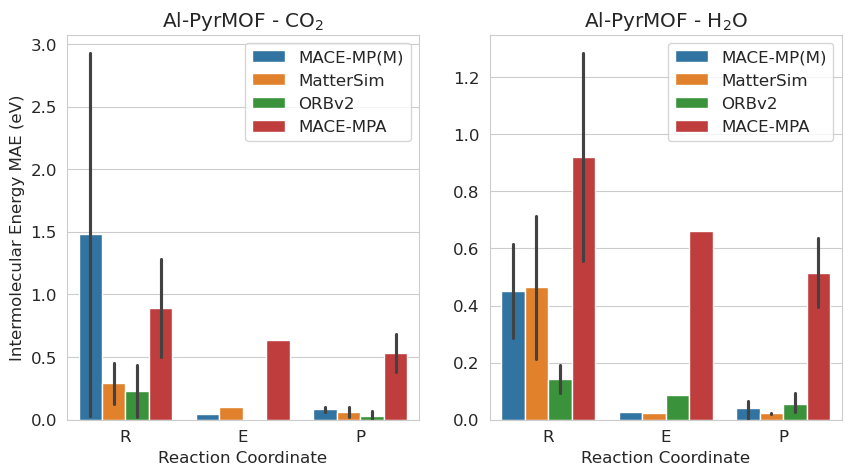

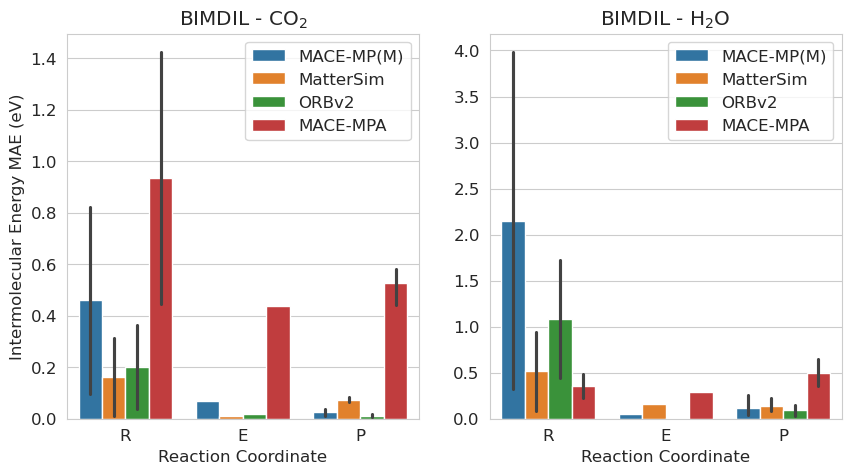

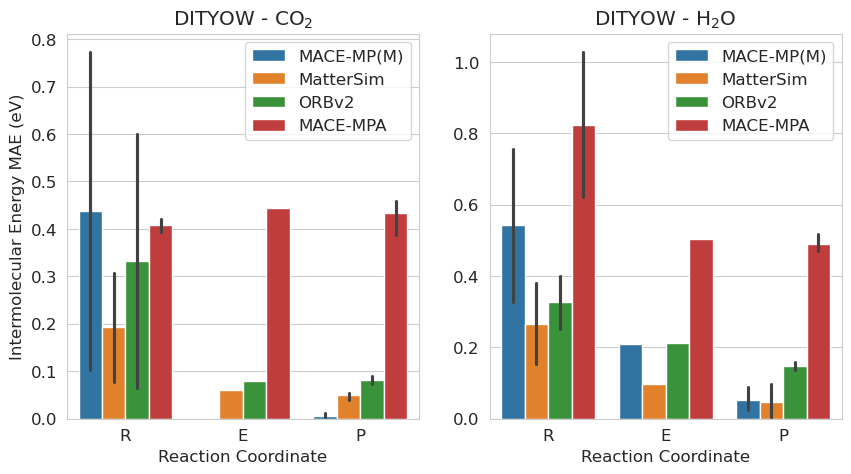

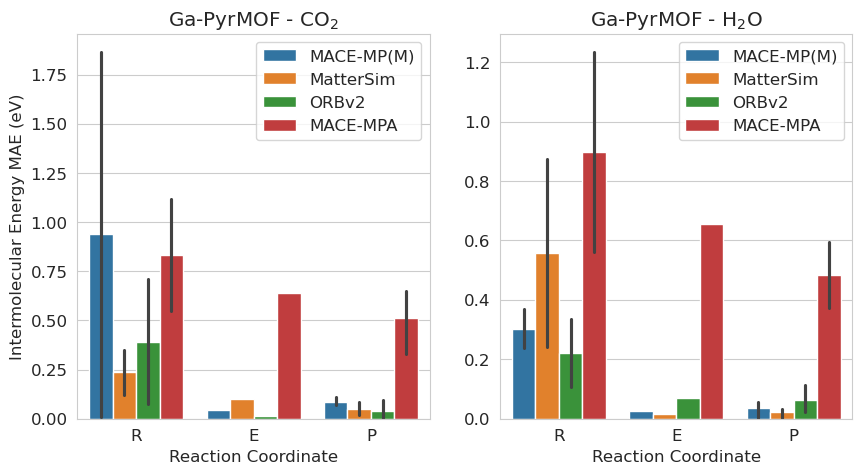

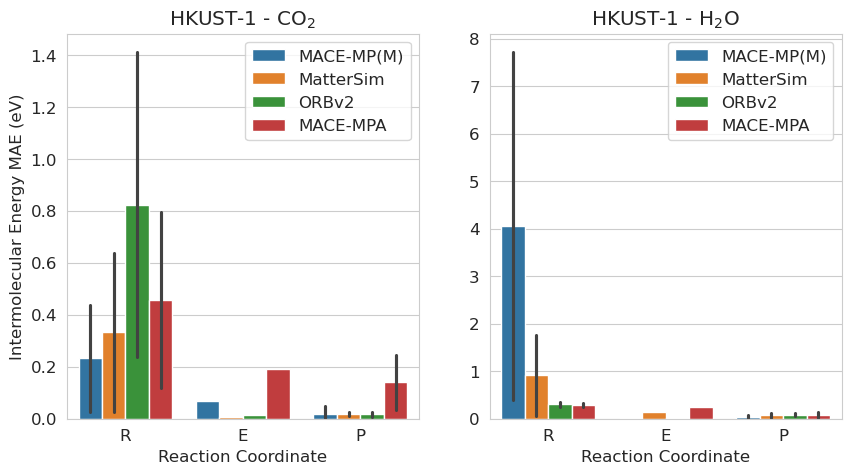

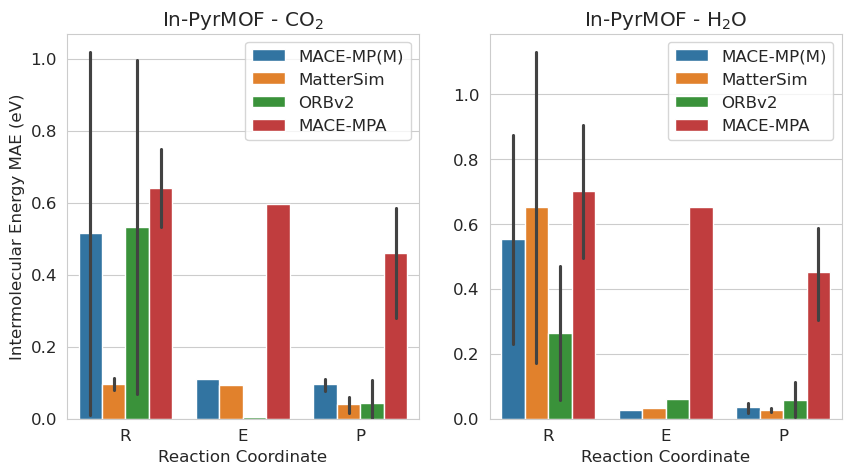

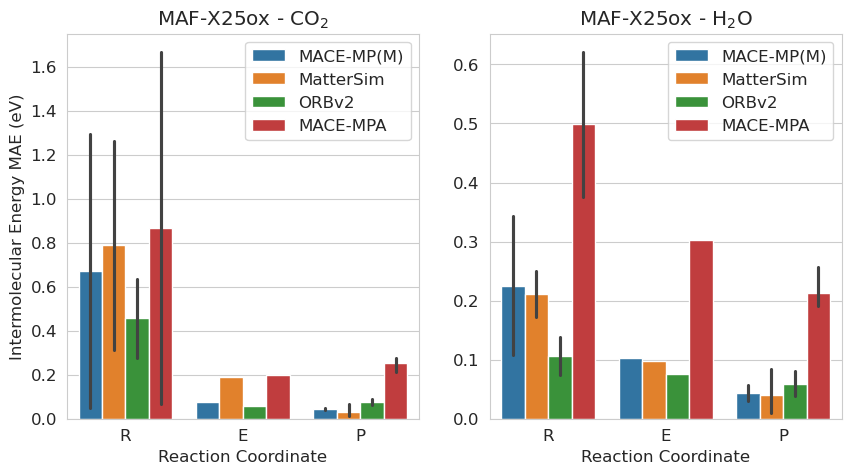

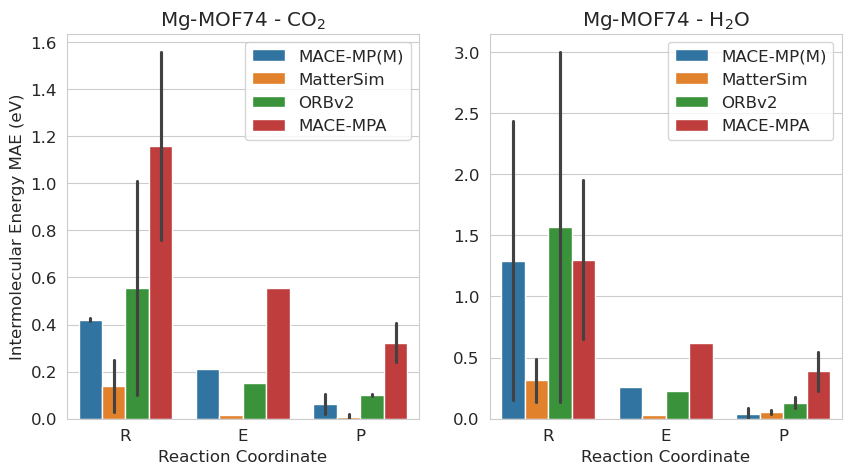

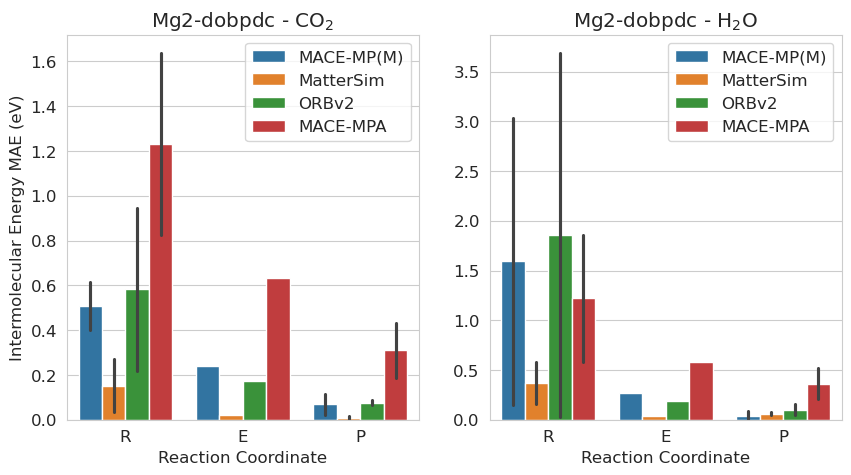

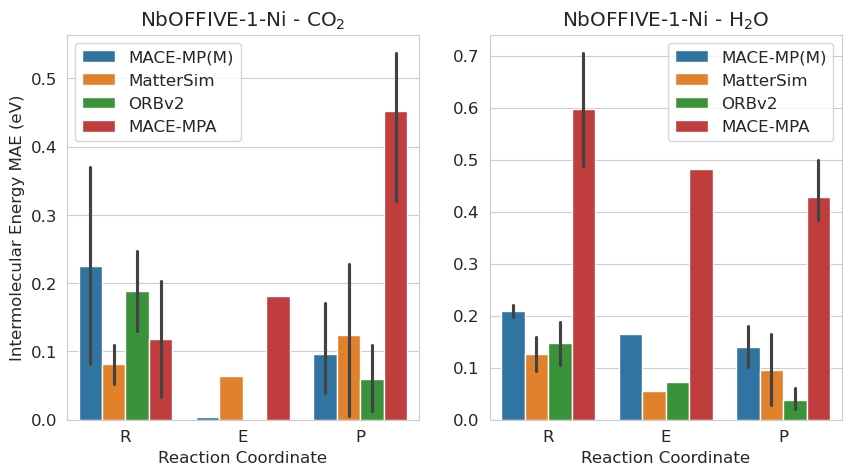

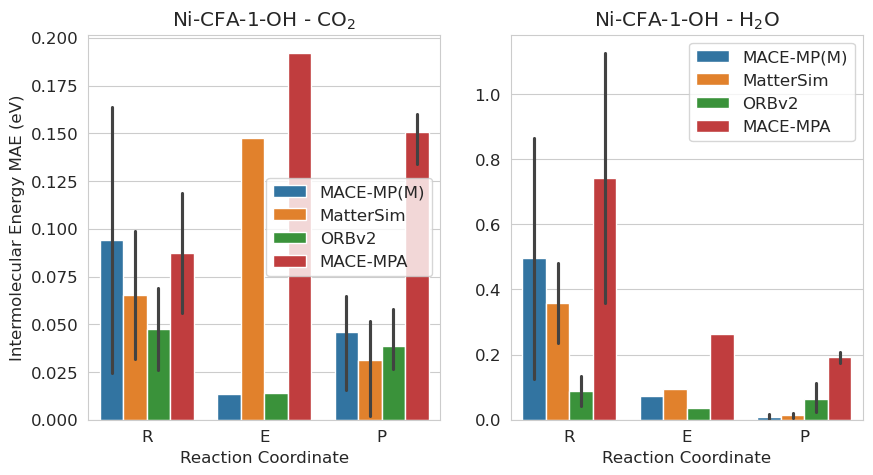

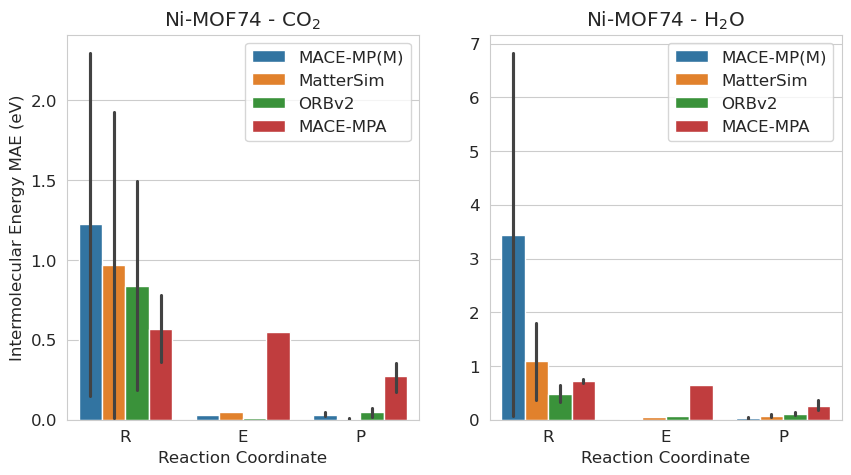

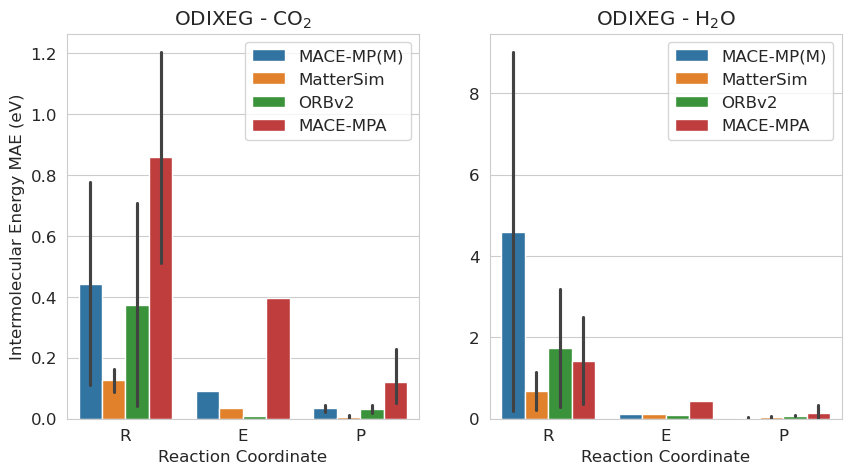

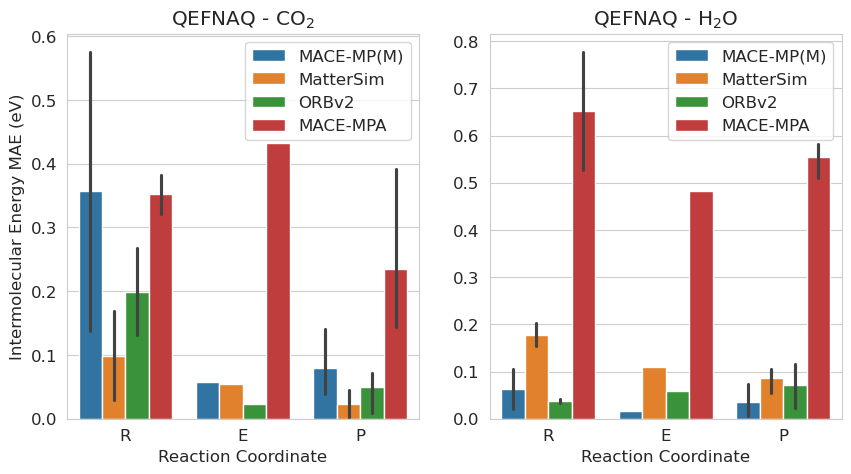

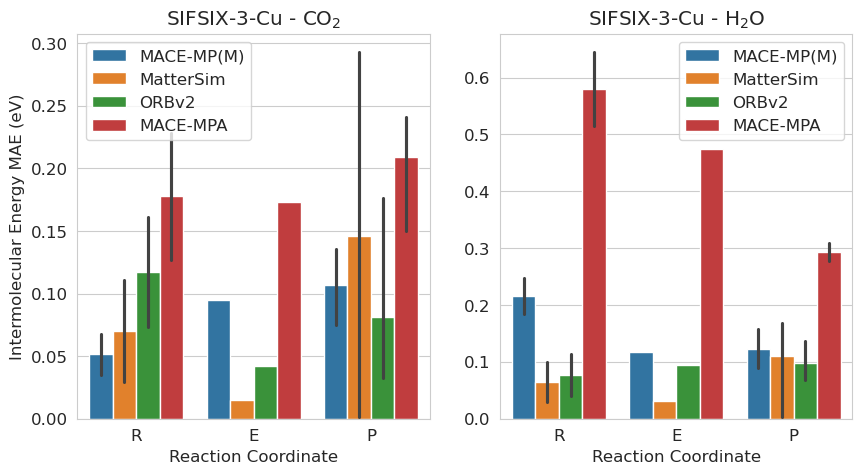

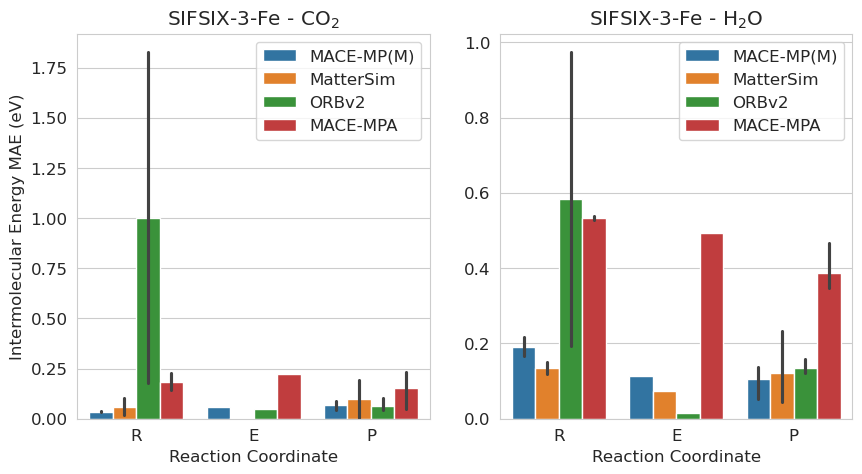

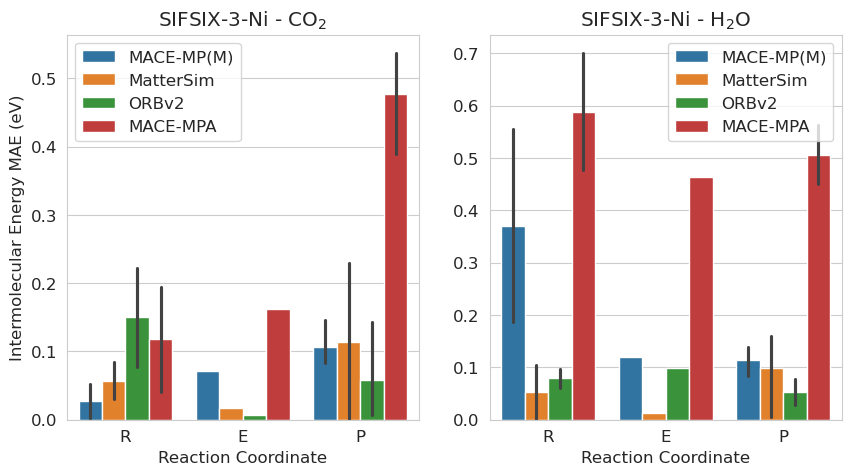

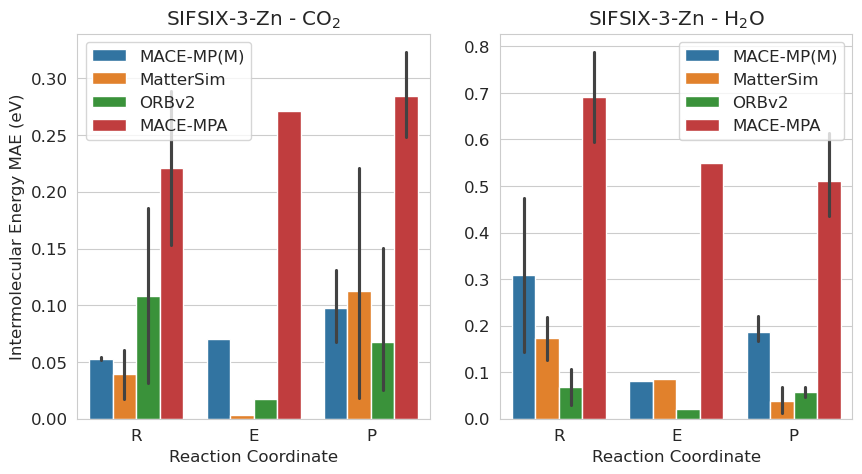

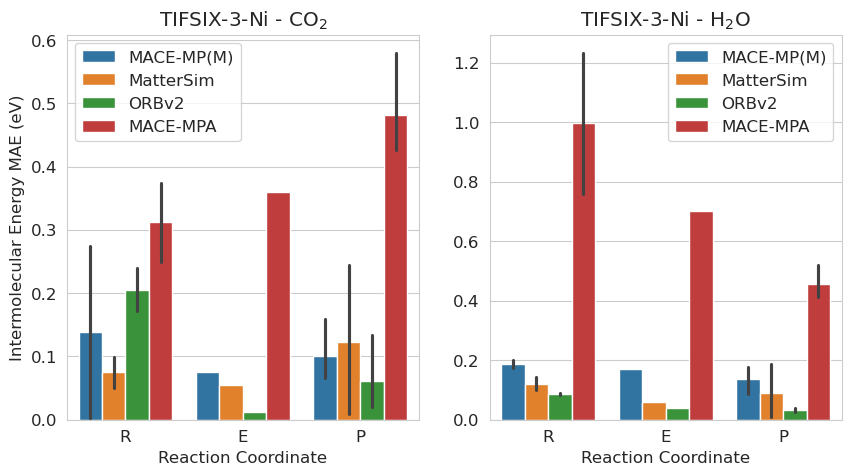

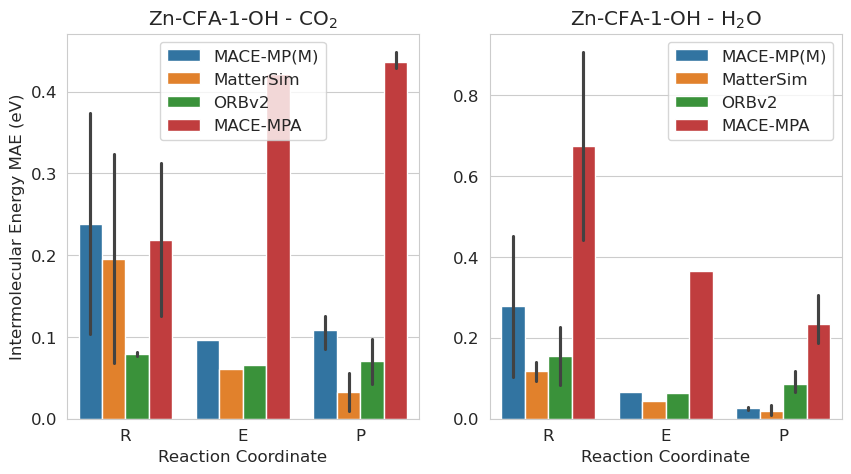

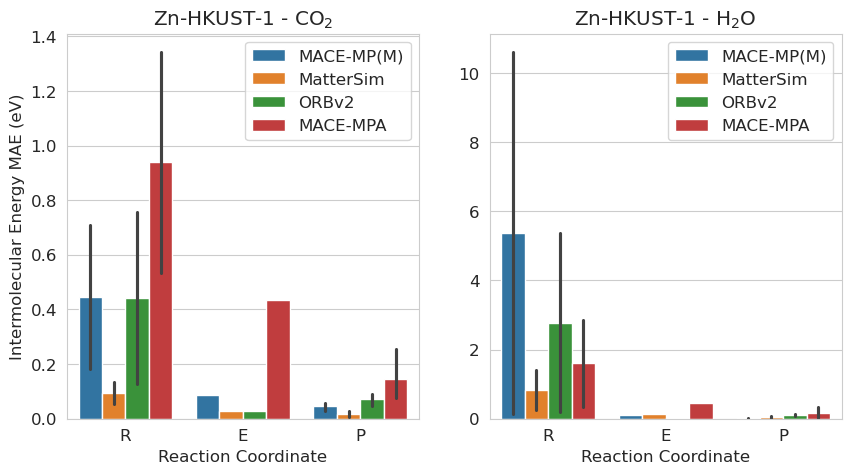

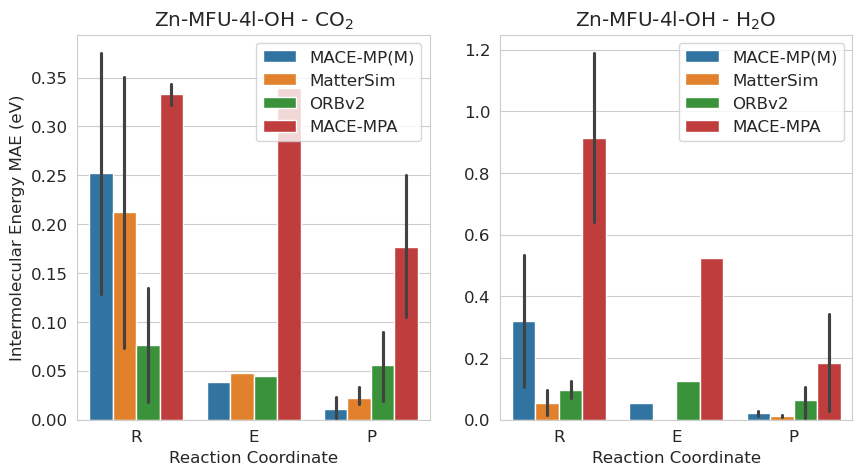

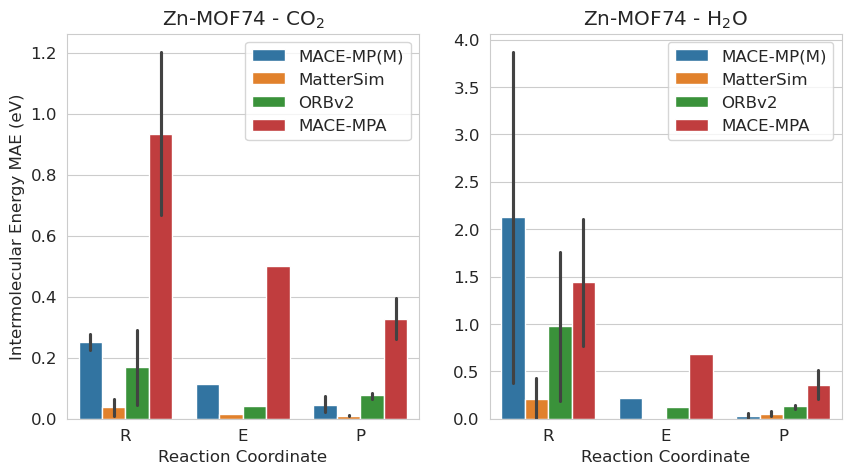

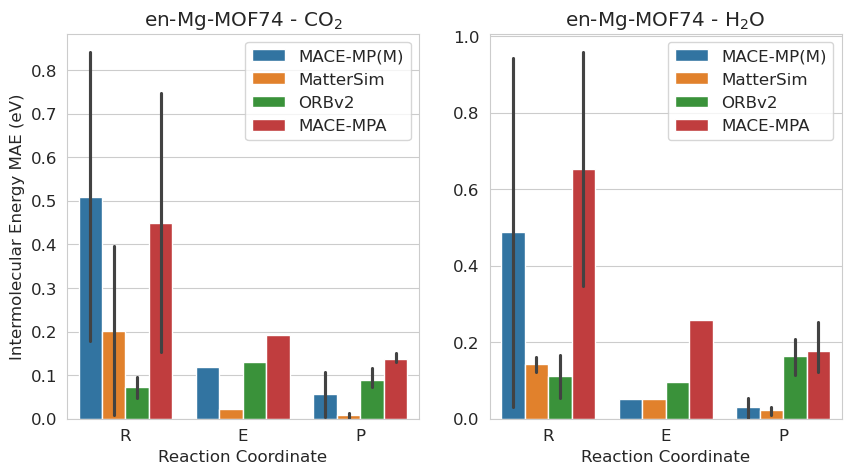

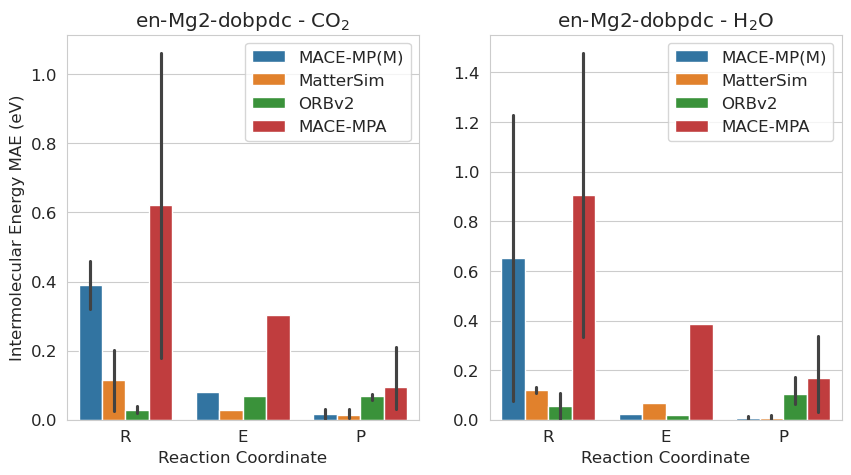

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
plt.rcParams["font.size"] = 12

for mof_name, mof_df in df.groupby("mof_name"):
    # Sort by region and distance
    df_co2 = mof_df[mof_df["gas"] == "CO2"].sort_values(["region", "dist"])
    df_h2o = mof_df[mof_df["gas"] == "H2O"].sort_values(["region", "dist"])
    region_order = {"R": 0, "E": 1, "P": 2}
    df_co2 = df_co2.sort_values(by=["region", "dist"], key=lambda x: x.map(region_order))
    df_h2o = df_h2o.sort_values(by=["region", "dist"], key=lambda x: x.map(region_order))

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 
    # CO2
    ax = axes[0]

    # sns.lineplot(
    #     data=df_co2.drop_duplicates(subset=['true_ie']), 
    #     x=["R1", "R2", "E", "W1", "W2", "W3"], y="true_ie", 
    #     ax=ax, label='PBE+D3'
    # )

    # for model_name, model_df in df_co2.groupby("model"):
    #     sns.lineplot(data=model_df, x=["R1", "R2", "E", "W1", "W2", "W3"], y="mae_ie", ax=ax, label=model_name+'+D3')
    sns.barplot(data=df_co2, x="region", y="mae_ie", ax=ax, hue="model")
        
    ax.set_title(f"{mof_name} - CO$_2$")
    ax.set_ylabel("Intermolecular Energy MAE (eV)")
    ax.set_xlabel("Reaction Coordinate")
    ax.legend()
    # H2O
    ax = axes[1]

    # sns.lineplot(
    #     data=df_h2o.drop_duplicates(subset=['true_ie']), 
    #     x=["R1", "R2", "E", "W1", "W2", "W3"], y="true_ie", 
    #     ax=ax, label='PBE+D3'
    # )
    
    # for model_name, model_df in df_h2o.groupby("model"):
    #     sns.lineplot(data=model_df, x=["R1", "R2", "E", "W1", "W2", "W3"], y="mae_ie", ax=ax, label=model_name+'+D3')
    sns.barplot(data=df_h2o, x="region", y="mae_ie", ax=ax, hue="model")
        
    
    # sns.lineplot(data=df_h2o, x=["R1", "R2", "E", "W1", "W2", "W3"], y="pred_ie", ax=ax, label=model.name+'+D3')
    axes[1].set_title(f"{mof_name} - H$_2$O")
    axes[1].set_ylabel(None)
    axes[1].set_xlabel("Reaction Coordinate")
    ax.legend()
    plt.show()
